# Прогнозирование оттока клиентов из компании «ТелеДом»


**Описание проекта**: Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

Оператор предоставляет два основных типа услуг: 
- *Стационарную телефонную связь*. Телефон можно подключить к нескольким линиям одновременно.
- *Интернет*. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
- Также доступны такие услуги:
    - *Интернет-безопасность*: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    - *Выделенная линия технической поддержки (TechSupport)*;
    - *Облачное хранилище файлов для резервного копирования данных (OnlineBackup)*;
    - *Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies)*.

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Цель исследования**: Построить модель машинного обучения, с помощью которой появится возможность прогноза оттока клиентов.

**Ход исследования:**
- *Шаг 1.* Загрузка данных и первичная подготовка данных.
- *Шаг 2.* Объединение данных, исследовательский анализ и их предобработка.
- *Шаг 3.* Обучение и анализ моделей.
- *Шаг 4.* Общий вывод и рекомендации заказчику.

**Общий вывод**: По итогам проведенного анализа и разработки модели машинного обучения появится возможность прогнозировать отток клиентов и предлагать им промокоды и специальные условия, что снизит потенциальные риски и финансовые потери компании «ТелеДом». 

**Описание данных**

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Данные состоят из нескольких файлов, полученных из разных источников, со следующими признаками:
- **`contract_new.csv` — информация о договоре;**
    - `customerID` — идентификатор абонента;
    - `BeginDate` — дата начала действия договора;
    - `EndDate` — дата окончания действия договора;
    - `Type` — тип оплаты: раз в год-два или ежемесячно;
    - `PaperlessBilling` — электронный расчётный лист;
    - `PaymentMethod` — тип платежа;
    - `MonthlyCharges` — расходы за месяц;
    - `TotalCharges` — общие расходы абонента.
    
    
- **`personal_new.csv` — персональные данные клиента;**
    - `customerID` — идентификатор пользователя;
    - `gender` — пол;
    - `SeniorCitizen` — является ли абонент пенсионером;
    - `Partner` — есть ли у абонента супруг или супруга;
    - `Dependents` — есть ли у абонента дети.
    
    
- **`internet_new.csv` — информация об интернет-услугах;**
    - `customerID` — идентификатор пользователя;
    - `InternetService` — тип подключения;
    - `OnlineSecurity` — блокировка опасных сайтов;
    - `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
    - `DeviceProtection` — антивирус;
    - `TechSupport` — выделенная линия технической поддержки;
    - `StreamingTV` — стриминговое телевидение;
    - `StreamingMovies` — каталог фильмов.
    
    
- **`phone_new.csv` — информация об услугах телефонии.**
    - `customerID` — идентификатор пользователя;
    - `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020 года.

## Загрузка и подготовка данных.

### Импортирование библиотек

In [1]:
# Установим библиотеки, которые понадобятся для работы над проектом. 

!pip install -q phik
!pip install -q shap
!pip install -q lightgbm

# Переустанавливаем версию matplotlib для визуализации SHAP
!pip install -q matplotlib==3.5.1

# Обновляем scikit-learn, так как выдавал ошибки при запуске кода из теории
!pip install -Uq scikit-learn

In [2]:
# Импортируем библиотеки, которые понадобятся для работы над проектом. 
import time
import warnings
from tqdm.notebook import tqdm

# для датафрейма 
import pandas as pd
import numpy as np

# для визуализации 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# для статистики
import phik
from phik import report
from phik.report import plot_correlation_matrix
from scipy import stats as st

# для машинного обучения
import shap
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

# модели 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV 

# метрики
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay 

In [3]:
# Проверим версию matplotlib

print(matplotlib.__version__)

3.5.1


In [4]:
# Зафисируем константы

RANDOM_STATE = 201025

### Загрузка данных 

In [5]:
# Считаем данные из csv-файла в датафрейм и сохраним в переменную. 

try:
    contract = pd.read_csv('/datasets/contract_new.csv', parse_dates=['BeginDate'])
except:
    contract = pd.read_csv('https://code.s3.yandex.net//datasets/contract_new.csv', parse_dates=['BeginDate'])
    
try:
    personal = pd.read_csv('/datasets/personal_new.csv')
except:
    personal = pd.read_csv('https://code.s3.yandex.net//datasets/personal_new.csv')

try:
    internet = pd.read_csv('/datasets/internet_new.csv')
except:
    internet = pd.read_csv('https://code.s3.yandex.net//datasets/internet_new.csv')
    
try:
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    phone = pd.read_csv('https://code.s3.yandex.net//datasets/phone_new.csv')

In [6]:
# Функция вывода основной информации о файлах-датафреймах

def main_info(df):
    # Информация о структуре датафрейма
    print("Информация о структурах:")
    df.info()
    print("\n")
    display(df.shape)
    print('-----')
    
    # Статистическое описание колонок
    print("Статистика:")
    display(df.describe().T)
    print("\n")
    print('-----')
    
    # Первые десять строк датафрейма
    print("Первые строки:")
    display(df.head(10))
    print("\n")
    print('-----')
    
    # Информация о дубликатах
    print("Количество явных дубликатов в датафрейме:")
    display(df.duplicated().sum())
    print("\n")
    print('-----')
    
    # Информация о пропусках
    print("Количество пропусков в датафрейме:")
    display(df.isna().sum())
    print("\n")
    print('-----')

In [7]:
# Выведем основную информацию о датафрейме contract
main_info(contract)

Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB




(7043, 8)

-----
Статистика:


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75




-----
Первые строки:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35




-----
Количество явных дубликатов в датафрейме:


0



-----
Количество пропусков в датафрейме:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64



-----


**Комментарии**

Датасет из файла `contract_new.csv` мы сохранили в переменную `contract`. Он содержит 7043 строки, пропусков и явных дубликатов нет. Необходимо поменять тип данных в столбце `TotalCharges`. Названия столбцов не соответствуют правилам snake_case, используется CamelCase, но это не критично, изменять не будем. Статистические показатели выглядят правдоподобно. 
 

In [8]:
# Выведем основную информацию о датафрейме personal 

main_info(personal)

Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB




(7043, 5)

-----
Статистика:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0




-----
Первые строки:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes




-----
Количество явных дубликатов в датафрейме:


0



-----
Количество пропусков в датафрейме:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64



-----


**Комментарии**

Датасет из файла `personal_new.csv` мы сохранили в переменную `personal`. Он содержит 7043 строки, пропусков и явных дубликатов нет. На первый взгляд тип данных выглядят корректно, но возможно имеет смысл поменять значения в столбце `SeniorCitizen` на "Yes" и "No" вместо "0" и "1" для единообразия. Названия столбцов не соответствуют правилам snake_case, используется CamelCase, это не критично, изменять не будем.

In [9]:
# Выведем основную информацию о датафрейме internet 

main_info(internet)

Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB




(5517, 8)

-----
Статистика:


,count,unique,top,freq
customerID,5517,5517,6845-RGTYS,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785




-----
Первые строки:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No




-----
Количество явных дубликатов в датафрейме:


0



-----
Количество пропусков в датафрейме:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64



-----


**Комментарии**

Датасет из файла `internet_new.csv` мы сохранили в переменную `internet`. Он содержит 5517 строк, пропусков и явных дубликатов нет. На первый взгляд тип данных выглядят корректно. Названия столбцов не соответствуют правилам snake_case, используется CamelCase, это не критично, изменять не будем. Статистические показатели выглядят правдоподобно.

In [10]:
# Выведем основную информацию о датафрейме phone

main_info(phone)

Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB




(6361, 2)

-----
Статистика:


,count,unique,top,freq
customerID,6361,6361,3096-GKWEB,1
MultipleLines,6361,2,No,3390




-----
Первые строки:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes




-----
Количество явных дубликатов в датафрейме:


0



-----
Количество пропусков в датафрейме:


customerID       0
MultipleLines    0
dtype: int64



-----


**Комментарии**

Датасет из файла `phone_new.csv` мы сохранили в переменную `phone`. Он содержит 6361 строку, пропусков и явных дубликатов нет. На первый взгляд тип данных выглядят корректно. Названия столбцов не соответствуют правилам snake_case, используется CamelCase, это не критично, изменять не будем. Статистические показатели выглядят правдоподобно.

**Вывод**

Полученные данные мы сохранили в четыре переменные: `contract` для данных о договорах; `personal` с персональными данными клиентов; `internet` с информацией об интернет-услугах; `phone` с информацией об услугах телефонии. В датафреймах нет пропусков и дубликатов, но требуется изменить тип данных нескольких переменных. На текущем этапе данные соответствуют описанию задачи. 

### Преобразование типов данных


In [11]:
# Изменим тип данных в указанных столбцах

contract['TotalCharges']  = np.floor(pd.to_numeric(contract['TotalCharges'], errors='coerce')).astype('float64')

# Проверим появились ли в данных явные строки-дубликаты или пропуски. 

print('Количество явных дубликатов в датафрейме contract:', contract.duplicated().sum())
display(contract.loc[contract.duplicated(keep=False)])
print('Пропущенные значения в датафрейме contract: \n', contract.isna().sum())
display(contract[contract['TotalCharges'].isnull()])


Количество явных дубликатов в датафрейме contract: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


Пропущенные значения в датафрейме contract: 
 customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


**Комментарии**

После преобразования типа данныз появились пропуске в столбце `TotalCharges`. Изучив эти пропуски можно сделать вывод, что столбец пуст `TotalCharges`, так как дата начала действия договора совпадает с датой выгрузки данных, таким образом это абоненты с длительностью контракта - 0 дней. Заменим такие пропуски на 0.

In [12]:
# Заполняем возникшие пропуски

contract['TotalCharges'] = contract['TotalCharges'].fillna(0)

# Проверим появились ли в данных явные строки-дубликаты или пропуски. 

print('Количество явных дубликатов в датафрейме contract:', contract.duplicated().sum())
display(contract.loc[contract.duplicated(keep=False)])
print('Пропущенные значения в датафрейме contract: \n', contract.isna().sum())
display(contract[contract['TotalCharges'].isnull()])

Количество явных дубликатов в датафрейме contract: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


Пропущенные значения в датафрейме contract: 
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [13]:
# Изменим тип данных в указанных столбцах

personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('str')

# Произведем замены

personal['SeniorCitizen'] = (
    personal['SeniorCitizen']
    .str.replace('0', 'No')
    .str.replace('1', 'Yes')
) 

# Проверим появились ли в данных явные строки-дубликаты или пропуски. 

print('Количество явных дубликатов в датафрейме contract:', personal.duplicated().sum())
display(personal.loc[personal.duplicated(keep=False)])
print('Пропущенные значения в датафрейме contract: \n', personal.isna().sum())
display(personal[personal['SeniorCitizen'].isnull()])
display(personal.head(5))


Количество явных дубликатов в датафрейме contract: 0


,customerID,gender,SeniorCitizen,Partner,Dependents


Пропущенные значения в датафрейме contract: 
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


,customerID,gender,SeniorCitizen,Partner,Dependents


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


### Исследовательский анализ 

#### Датафрейм `contract`

In [14]:
# Посмотрим на уникальные значения в категориальных данных в датафрейме

print('Датафрейм "contract"')
print('Дата окончания действия договора:', contract['EndDate'].unique())
print('Тип оплаты:', contract['Type'].unique())
print('Электронный расчетный лист:', contract['PaperlessBilling'].unique())
print('Тип платежа:', contract['PaymentMethod'].unique())


Датафрейм "contract"
Дата окончания действия договора: ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']
Тип оплаты: ['Month-to-month' 'One year' 'Two year']
Электронный ра

**Комментарии**

Неявных дубликатов в датафрейме нет, все в порядке. Столбец `EndDate` содержит как даты, так и значение 'No', которое необходимо будет в дальнейшем заменить и преобразовать в тип `datetime` для подсчета длительности договора.

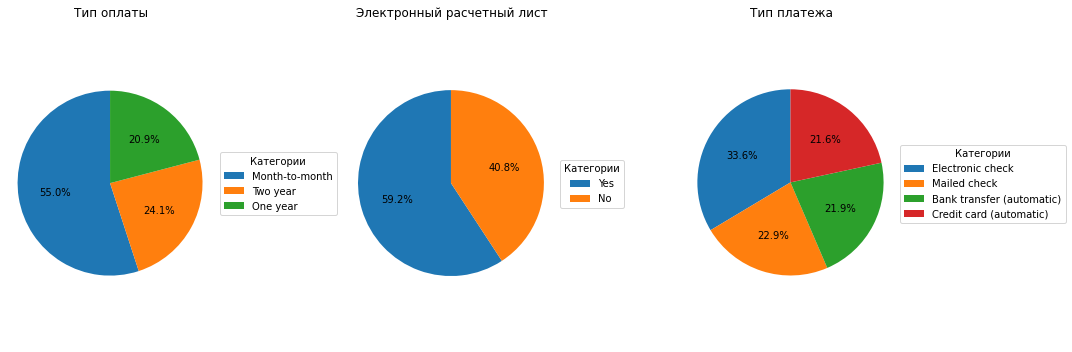

In [15]:
# Построим круговые диаграммы для всех категориальных столбцов на одном графике.

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Создаем сетку из 3x1 подграфиков
axes = axes.flatten()  # Преобразуем массив двумерный в одномерный

columns = ['Type', 'PaperlessBilling', 'PaymentMethod'] # Колонки для анализа
titles = ['Тип оплаты', 'Электронный расчетный лист', 'Тип платежа']  # Заголовки для осей

# Проход по колонкам и создание круговых диаграмм
for i, (col, title) in enumerate(zip(columns, titles)):
    if i >= len(axes):
        break
    
    counts = contract[col].value_counts().sort_values(ascending=False)  # Подсчет количества записей для каждого значения
    labels = counts.index  # Метки категорий
    sizes = counts.values  # Доли значений
    
    # Построение круговой диаграммы
    wedges, texts, autotexts = axes[i].pie(sizes, labels=None, autopct='%1.1f%%', startangle=90)
    axes[i].legend(wedges, labels,
                   title="Категории",
                   loc="center left",
                   bbox_to_anchor=(1, 0, 0.5, 1))
    axes[i].set_title(title)
    axes[i].axis('equal')  # Устанавливаем равный масштаб осей, чтобы получился правильный круг

    
plt.tight_layout()  
plt.show()

**Комментарии**

Изучая категориальные признаки в датафрейме, можно сделать следующие выводы:
- Больше половины абонентов (55%) используют помесячную оплату услуг. Второй по популярности идет оплата за два года (24.1%), за ними оплата за один год (20.9%).
- Почти 60% абонентов используют электронный расчетный счет. 
- Распределение типов платежей примерно равномерно (20-30%), преобладает элетронная оплата. 

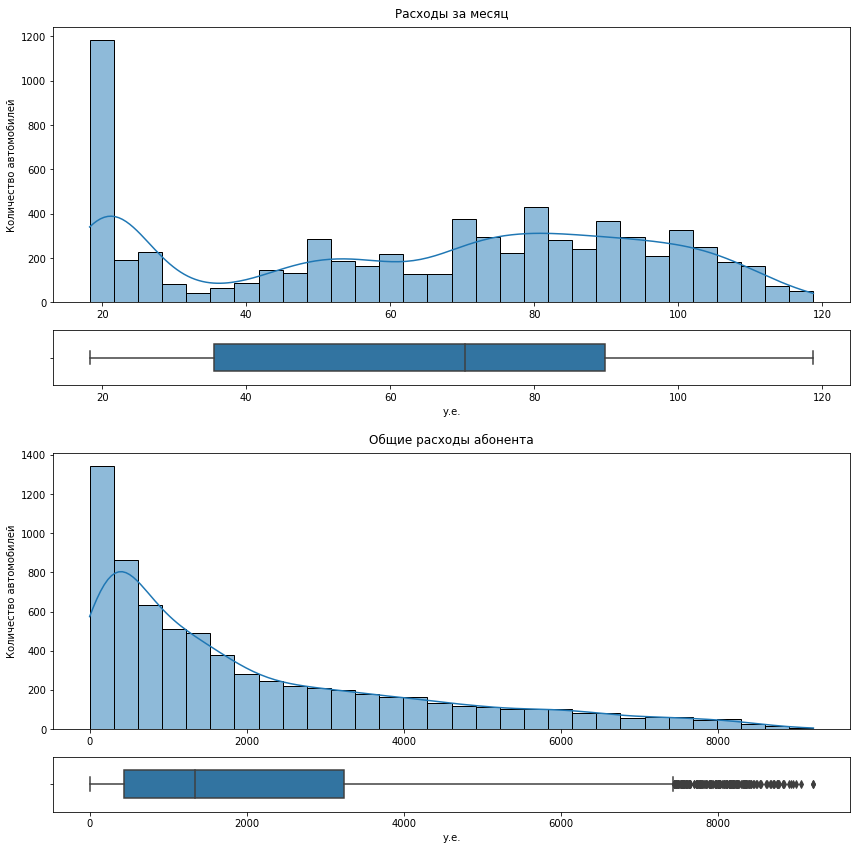

Статистика:


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043.0,2114.859009,2112.745015,0.00,436.5,1343.00,3236.00,9221.00


In [16]:
# Построим гистограммы и диаграмма размаха для всех непрерывных числовых столбцов таблицы на одном графике.

columns = ['MonthlyCharges', 'TotalCharges'] # Колонки для анализа
titles = ['Расходы за месяц', 'Общие расходы абонента']  # Заголовки для осей
xlabels = ['у.е.', 'у.е.']  # Подписи оси X

# Создаем фигуру с 2 рядами и 1 колонкой 
fig, axes = plt.subplots(len(columns), 1, figsize=(12, 12))

# Для каждого столбца создаем две оси (гистограмма + боксплот)
for i, col in enumerate(columns):
        
    # Разделяем текущую ось на две: верхнюю (гистограмма) и нижнюю (боксплот)
    ax_hist = axes[i]  # Гистограмма будет здесь
    ax_box = ax_hist.inset_axes([0, -0.3, 1, 0.2])  # Боксплот внизу
    
    # Гистограмма
    sns.histplot(data=contract, x=col, ax=ax_hist, bins=30, kde=True)
    ax_hist.set_title(titles[i], pad=10)
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('Количество автомобилей')
    
    # Боксплот
    sns.boxplot(x=contract[col], orient='h', ax=ax_box, width=0.5) 
    ax_box.set_xlabel(xlabels[i])
    ax_box.set_ylabel('')
    
    # Синхронизация осей X
    x_min = min(contract[col].min(), ax_box.get_xlim()[0])
    x_max = max(contract[col].max(), ax_box.get_xlim()[1])
    ax_hist.set_xlim(x_min, x_max)
    ax_box.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

print("Статистика:")
display(contract.describe().T)

**Комментарии**

Изучая числовые признаки в датафрейме, можно сделать следующие выводы:
- Гистограммы распределения расходов на месяц и общих расходов абонентов не похожи на нормальное распределение. 
- Большое количество абонентов имеют минимальные расходы за месяц (около 20), далее с увеличение трат есть также несколько небольших пиков (50, 70, 80, 90, 100), возможно это цены на базовые тарифы без доп.услуг. 
- Рассматривая гистограмму общих трат также можно заметить пик в самом начале, из чего можно предположить, что в датасете много абонентов, которые недавно зарегистрировались или недолго пользовались услугали компании. Возможно, такое распределение отражает популярную тенденцию промо-тарифов для новых пользователей. Более того, 75% абонентов имеют расходы не более 3236, при максимальном значении в 9221.
- Выбросов в данных данных о ежемесячных расходах нет, среднее значение близко к медианному. В данных об общих расходах абонентов, наоборот, имеется большое количество выбросов из-за чего среднее и медианное значения отличаются практически вдвое. 

#### Датафрейм `personal`

In [17]:
# Посмотрим на уникальные значения в категориальных данных в датафрейме

print('Датафрейм "personal"')
print('Пол:', personal['gender'].unique())
print('Статус пенсионера:', personal['SeniorCitizen'].unique())
print('Наличие супруга/супруги:', personal['Partner'].unique())
print('Наличие детей:', personal['Dependents'].unique())


Датафрейм "personal"
Пол: ['Female' 'Male']
Статус пенсионера: ['No' 'Yes']
Наличие супруга/супруги: ['Yes' 'No']
Наличие детей: ['No' 'Yes']


**Комментарии**

Неявных дубликатов в датафрейме нет, все в порядке. 

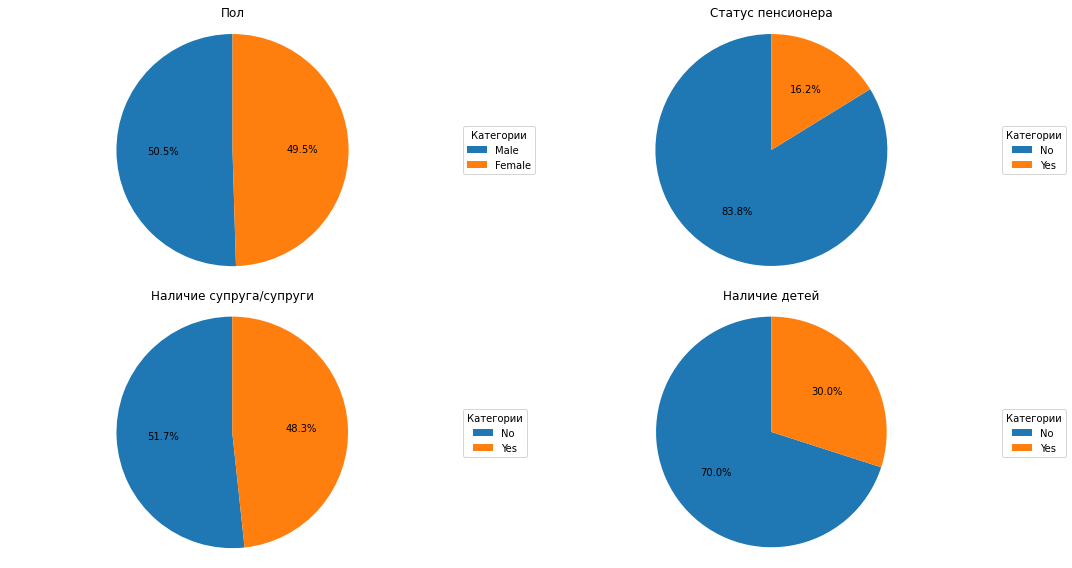

In [18]:
# Построим круговые диаграммы для всех категориальных столбцов на одном графике.

fig, axes = plt.subplots(2, 2, figsize=(15, 8))  # Создаем сетку из 2x2 подграфиков
axes = axes.flatten()  # Преобразуем массив двумерный в одномерный

columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents'] # Колонки для анализа
titles = ['Пол', 'Статус пенсионера', 'Наличие супруга/супруги', 'Наличие детей']  # Заголовки для осей

# Проход по колонкам и создание круговых диаграмм
for i, (col, title) in enumerate(zip(columns, titles)):
    if i >= len(axes):
        break
    
    counts = personal[col].value_counts().sort_values(ascending=False)  # Подсчет количества записей для каждого значения
    labels = counts.index  # Метки категорий
    sizes = counts.values  # Доли значений
    
    # Построение круговой диаграммы
    wedges, texts, autotexts = axes[i].pie(sizes, labels=None, autopct='%1.1f%%', startangle=90)
    axes[i].legend(wedges, labels,
                   title="Категории",
                   loc="center left",
                   bbox_to_anchor=(1, 0, 0.5, 1))
    axes[i].set_title(title)
    axes[i].axis('equal')  # Устанавливаем равный масштаб осей, чтобы получился правильный круг

    
plt.tight_layout()  
plt.show()

**Комментарии**

Изучая категориальные признаки в датафрейме, можно сделать следующие выводы:
- Распределение абонентов по полу, также как и по семейному положению, практически одинаковое 50.5% / 49.5% и 51.7% / 48.3% соответственно.
- Всего 16.2% абонентов являются пенсионерами. 
- Большая часть абонентов не имеют детей (70%). 

#### Датафрейм `internet` и `phone`

In [19]:
# Посмотрим на уникальные значения в категориальных данных в датафрейме

print('Датафрейм "internet"')
print('Тип подключения:', internet['InternetService'].unique())
print('Блокировка опасных сайтов:', internet['OnlineSecurity'].unique())
print('Облачное хранилище :', internet['OnlineBackup'].unique())
print('Антивирус:', internet['DeviceProtection'].unique())
print('Выделенная линия технической поддержки:', internet['TechSupport'].unique())
print('Стриминговое телевидение:', internet['StreamingTV'].unique())
print('Каталог фильмов:', internet['StreamingMovies'].unique())
print()
print('Датафрейм "phone"')
print('Подключение телефона к нескольким линиям одновременно:', phone['MultipleLines'].unique())

Датафрейм "internet"
Тип подключения: ['DSL' 'Fiber optic']
Блокировка опасных сайтов: ['No' 'Yes']
Облачное хранилище : ['Yes' 'No']
Антивирус: ['No' 'Yes']
Выделенная линия технической поддержки: ['No' 'Yes']
Стриминговое телевидение: ['No' 'Yes']
Каталог фильмов: ['No' 'Yes']

Датафрейм "phone"
Подключение телефона к нескольким линиям одновременно: ['No' 'Yes']


**Комментарии**

Неявных дубликатов в датафреймах нет, все в порядке. Так как эти датафреймы включают не всех пользователей, то анализ распределения услуг мы проведем после их объединения.

**Вывод**

Предварительный исследовательский анализ и предобработка предоставленных данных были проведены, можно приступать к объединению датафреймов.

## Объединение данных, исследовательский анализ и их предобработка.


### Объединение данных

In [20]:
# Объединим датафреймы в один

teledom = pd.merge(contract, personal, on='customerID')  
teledom = teledom.merge(internet, on='customerID', how='left')
teledom = teledom.merge(phone, on='customerID', how='left')

# Проверим результат

main_info(teledom)


Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14 

(7043, 20)

-----
Статистика:


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043.0,2114.859009,2112.745015,0.00,436.5,1343.00,3236.00,9221.00




-----
Первые строки:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.0,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.0,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.0,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.0,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.0,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.0,Female,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.0,Male,No,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.0,Female,No,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.0,Female,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.0,Male,No,No,Yes,DSL,Yes,Yes,No,No,No,No,No




-----
Количество явных дубликатов в датафрейме:


0



-----
Количество пропусков в датафрейме:


customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64



-----


**Комментарии**

После объединения всех датафреймов в один появилось значительное количество пропусков, так как датафреймы `internet` и `phone` содержали данные не обо всех пользователях. Удалять такие строки с пропущенными значаниям здесь будет некорректно, так как пользователь мог просто не подключать определенный вид услуг. Поэтому такие пропуски мы заполним значением 'Not used'.

### Обработка пропусков

In [21]:
# Проверим количество пропущенных значений для каждого столбца 

print('Пропущенные значения в датафрейме teledom: \n', teledom.isna().sum())

Пропущенные значения в датафрейме teledom: 
 customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


In [22]:
# Заполним столбцы с пропусками значением 'Not used'

na_col = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
          'DeviceProtection',  'TechSupport', 'StreamingTV',
          'StreamingMovies', 'MultipleLines']

teledom[na_col] = teledom[na_col].fillna('Not used')

# Повторно проверим количество пропущенных значений для каждого столбца 

print('Пропущенные значения в датафрейме teledom: \n', teledom.isna().sum())

Пропущенные значения в датафрейме teledom: 
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


**Комментарии**

Пропуски заполнены, все в порядке, можно переходить к следующему шагу.

### Обработка дубликатов

In [23]:
# Проверим есть ли в данных явные строки-дубликаты. 

print('Количество явных дубликатов в датафрейме teledom:', teledom.duplicated().sum())
display(teledom.loc[teledom.duplicated(keep=False)])

Количество явных дубликатов в датафрейме teledom: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


**Комментарии**

Дубликатов не появилось, все в порядке, можно переходить к следующему шагу.

### Создание новых признаков

In [24]:
# Создадим целевой признак 'quit'. Если EndDate = 'No', то договор действителен (0), если есть дата - договор расторгнут (1)

teledom['quit'] = teledom['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

# Проверим результат

display(teledom.head(5))


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,quit
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.0,Female,No,...,No,DSL,No,Yes,No,No,No,No,Not used,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.0,Male,No,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.0,Male,No,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.0,Male,No,...,No,DSL,Yes,No,Yes,Yes,No,No,Not used,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.0,Female,No,...,No,Fiber optic,No,No,No,No,No,No,No,0


In [25]:
# Создадим признак 'period' с длительностью пользования услугами

teledom['EndDate'] = teledom['EndDate'].replace('No', '2020-02-01') # заменяем значение 'No' на дату выгрузки
teledom['EndDate'] = pd.to_datetime(teledom['EndDate']) # преобразуем тип данных
teledom['period'] = (teledom['EndDate'] - teledom['BeginDate']).dt.days # считаем количество дней
# teledom.loc[teledom['quit'] == 0, 'EndDate'] = 'No' # восстанавливаем изначальные значения в столбце 'EndDate'

# Проверим результат

display(teledom.head(5))


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,quit,period
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.0,Female,No,...,DSL,No,Yes,No,No,No,No,Not used,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.0,Male,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.0,Male,No,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.0,Male,No,...,DSL,Yes,No,Yes,Yes,No,No,Not used,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.0,Female,No,...,Fiber optic,No,No,No,No,No,No,No,0,153


**Комментарии**

На данном этапе мы создали два новых признака:
- `quit` - целевой признак (0 - договор действителен, 1 - договор расторгнут).
- `period` - количество дней использования договора.

### Исследовательский анализ данных

In [26]:
# Посмотрим на уникальные значения в категориальных данных в объединенном датафрейме

print('Датафрейм "teledom"')
print('Тип подключения:', teledom['InternetService'].unique())
print('Блокировка опасных сайтов:', teledom['OnlineSecurity'].unique())
print('Облачное хранилище :', teledom['OnlineBackup'].unique())
print('Антивирус:', teledom['DeviceProtection'].unique())
print('Выделенная линия технической поддержки:', teledom['TechSupport'].unique())
print('Стриминговое телевидение:', teledom['StreamingTV'].unique())
print('Каталог фильмов:', teledom['StreamingMovies'].unique())
print('Подключение телефона к нескольким линиям одновременно:', teledom['MultipleLines'].unique())

Датафрейм "teledom"
Тип подключения: ['DSL' 'Fiber optic' 'Not used']
Блокировка опасных сайтов: ['No' 'Yes' 'Not used']
Облачное хранилище : ['Yes' 'No' 'Not used']
Антивирус: ['No' 'Yes' 'Not used']
Выделенная линия технической поддержки: ['No' 'Yes' 'Not used']
Стриминговое телевидение: ['No' 'Yes' 'Not used']
Каталог фильмов: ['No' 'Yes' 'Not used']
Подключение телефона к нескольким линиям одновременно: ['Not used' 'No' 'Yes']


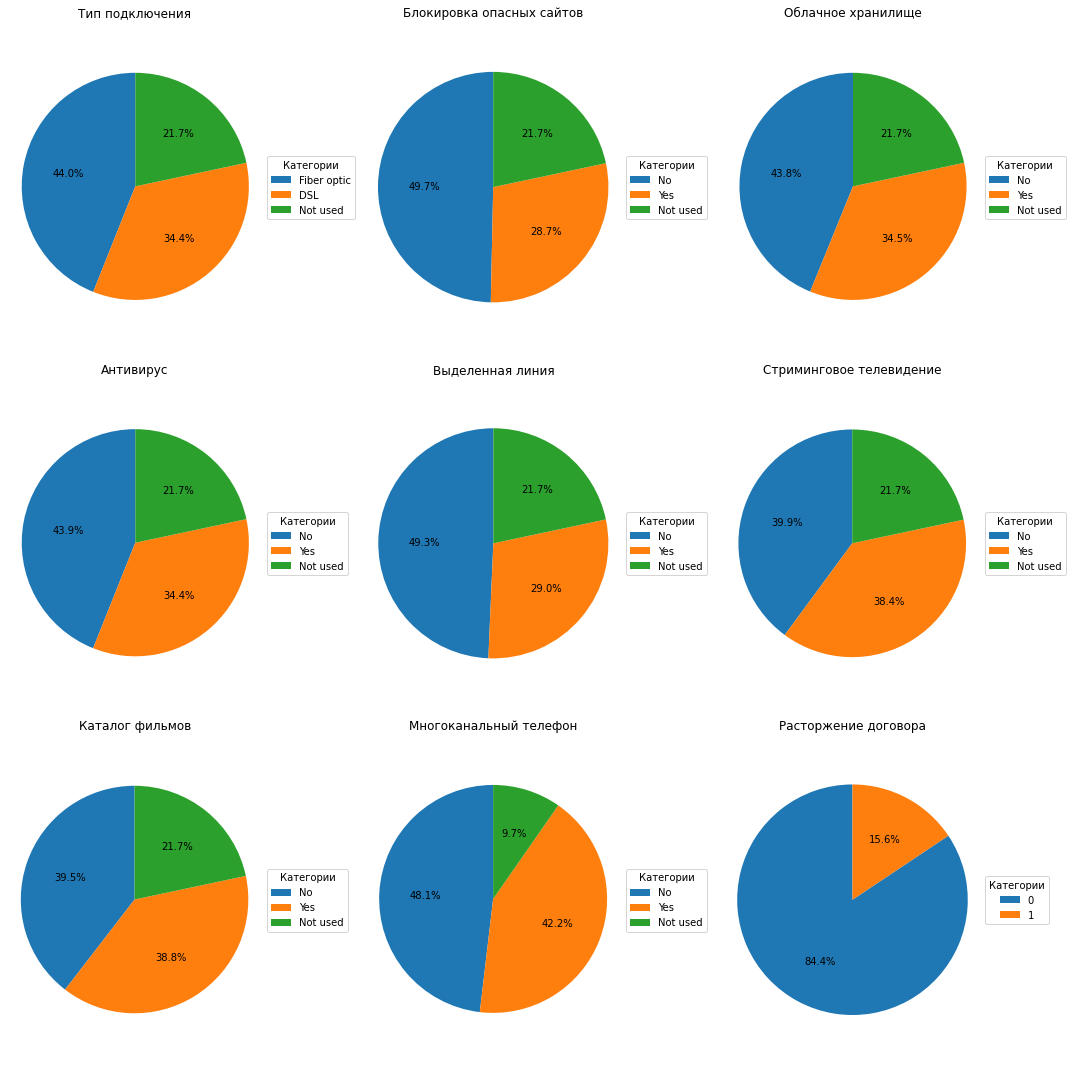

In [27]:
# Построим круговые диаграммы для всех новых признаков на одном графике.

fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Создаем сетку из 2x2 подграфиков
axes = axes.flatten()  # Преобразуем массив двумерный в одномерный

columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
          'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'quit'] # Колонки для анализа
titles = ['Тип подключения', 'Блокировка опасных сайтов', 'Облачное хранилище', 'Антивирус',
         'Выделенная линия', 'Стриминговое телевидение', 'Каталог фильмов', 
          'Многоканальный телефон', 'Расторжение договора']  # Заголовки для осей

# Проход по колонкам и создание круговых диаграмм
for i, (col, title) in enumerate(zip(columns, titles)):
    if i >= len(axes):
        break
    
    counts = teledom[col].value_counts().sort_values(ascending=False)  # Подсчет количества записей для каждого значения
    labels = counts.index  # Метки категорий
    sizes = counts.values  # Доли значений
    
    # Построение круговой диаграммы
    wedges, texts, autotexts = axes[i].pie(sizes, labels=None, autopct='%1.1f%%', startangle=90)
    axes[i].legend(wedges, labels,
                   title="Категории",
                   loc="center left",
                   bbox_to_anchor=(1, 0, 0.5, 1))
    axes[i].set_title(title)
    axes[i].axis('equal')  # Устанавливаем равный масштаб осей, чтобы получился правильный круг 
    
plt.tight_layout()  
plt.show()

**Комментарии**

Изучая категориальные признаки в объединенном датафрейме, можно сделать следующие выводы:
- 21.7% пользователей не используют услуги сети Интернет и дополнительные опции к ним.
- Услугой подключения телефона к нескольким линиям одновременно пользуются чуть больше 40% абонентов, а чуть меньше 10% абонентов не подключили телефонную связь вообще.
- Чуть меньше половины абонентов используют оптоволоконное подключение (44%).
- Около трети абоненты подключили допольнительную блокировку опасных сайтов (28.7%), облачное хранилище (34.5%), антивирус (34.4%) и отдельную выделенную линию технической поддержки (29%). 
- Примерно 40% пользователей используют стримминговое телевидение и каталог фильмов.
- Присутствует дисбаланс классов целевого признака: 84%/16%. В работе мы будем использовать метрику ROC-AUC, которая не чувствительна к дисбалансу, так что нет необходимости дополнять данные.


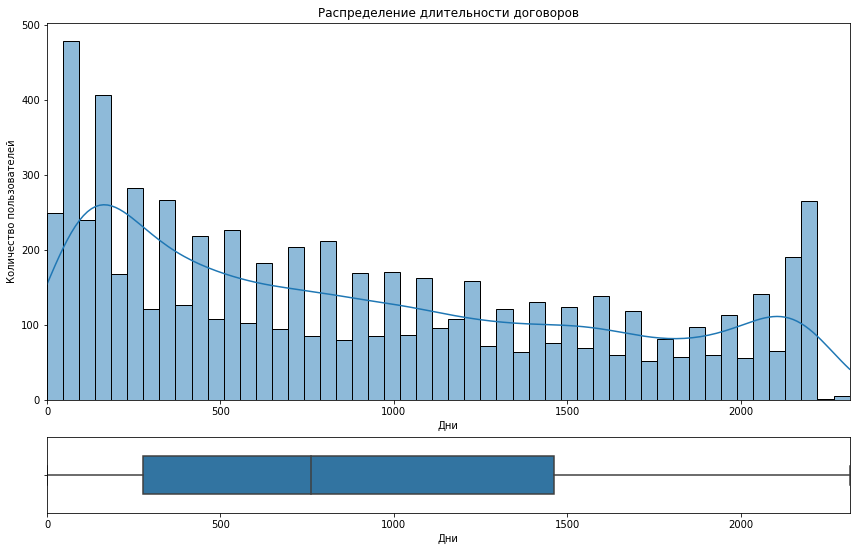

Статистика
count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: period, dtype: float64


In [28]:
# Построим гистограмму и диаграмму размаха для длительности договора в днях на одном графике.

fig, ax_hist = plt.subplots(figsize=(12, 8))  # Одна фигура и одна ось

# Гистограмма
sns.histplot(data=teledom, x="period", ax=ax_hist, bins=50, kde=True)
ax_hist.set_title("Распределение длительности договоров")
ax_hist.set_xlabel("Дни")
ax_hist.set_ylabel("Количество пользователей")

# Добавляем box-plot ниже гистограммы
ax_box = ax_hist.inset_axes([0, -0.3, 1, 0.2])  # Устанавливаем положение бокс-плота снизу
sns.boxplot(x=teledom["period"], orient='h', ax=ax_box, width=0.5)
ax_box.set_xlabel("Дни")  # Подпись оси X
ax_box.set_ylabel("")     # Убираем подпись оси Y

# Синхронизируем оси X
x_min = teledom["period"].min()
x_max = teledom["period"].max()
ax_hist.set_xlim(x_min, x_max)
ax_box.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

print('Статистика')
print(teledom["period"].describe())

**Комментарии**

Распределение длительности договоров похоже на расческу, среднее и медианное значения значительно отличаются друг от друга. График похож на мультимодальное распределение, что может указывать на наличие нескольких групп абонентов внутри данных. Самый длинный договор используется более 6 лет, а средняя длительность пользования услугами составляет 1,8-2 года. При этом важно отметить, что в данных довольно много абонентов, которые пользуются услугами меньше года.


### Корреляционный анализ

In [29]:
# Создаём список с наименованиями количественных признаков
interval_cols = ['MonthlyCharges', 'TotalCharges', 'period']

# Рассчитываем матрицу корреляций phi-k

corr_matrix = teledom.phik_matrix(interval_cols=interval_cols)
display(corr_matrix)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerID is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customerID can be slow.
  warnings.warn(


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,quit,period
customerID,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BeginDate,1.0,1.000000,0.548313,0.766249,0.081447,0.456389,0.421688,0.774010,0.011268,0.050862,...,0.192197,0.460712,0.496176,0.502422,0.455418,0.419599,0.431137,0.468035,0.450254,0.978521
EndDate,1.0,0.548313,1.000000,0.285429,0.062936,0.169262,0.173224,0.218035,0.018274,0.090502,...,0.117099,0.166235,0.236373,0.225828,0.150303,0.185980,0.199118,0.249504,1.000000,0.396342
Type,1.0,0.766249,0.285429,1.000000,0.106860,0.277462,0.388266,0.470275,0.000000,0.086231,...,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410,0.094015,0.634155
PaperlessBilling,1.0,0.081447,0.062936,0.106860,1.000000,0.370495,0.467783,0.201903,0.000000,0.242133,...,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953,0.083398,0.026799
PaymentMethod,1.0,0.456389,0.169262,0.277462,0.370495,1.000000,0.399536,0.335855,0.000000,0.292725,...,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849,0.214832,0.350964
MonthlyCharges,1.0,0.421688,0.173224,0.388266,0.467783,0.399536,1.000000,0.711090,0.009025,0.304691,...,0.918980,0.812633,0.818858,0.827318,0.816603,0.864642,0.863641,0.710101,0.225925,0.387579
TotalCharges,1.0,0.774010,0.218035,0.470275,0.201903,0.335855,0.711090,1.000000,0.000000,0.135994,...,0.490121,0.516470,0.550582,0.558337,0.527791,0.555457,0.554096,0.468127,0.303275,0.848097
gender,1.0,0.011268,0.018274,0.000000,0.000000,0.000000,0.009025,0.000000,1.000000,0.000000,...,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
SeniorCitizen,1.0,0.050862,0.090502,0.086231,0.242133,0.292725,0.304691,0.135994,0.000000,1.000000,...,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925,0.086159,0.063315


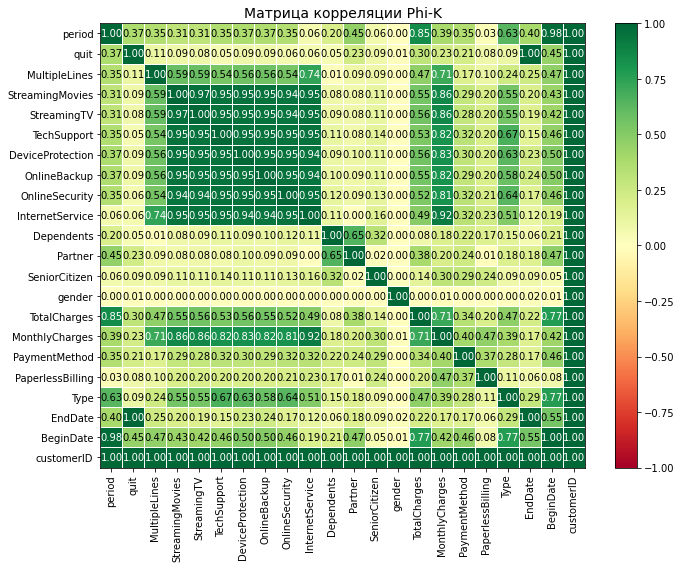

In [30]:
# Отображение корреляционной матрицы в виде тепловой карты

plot_correlation_matrix(corr_matrix.values,
                        x_labels=corr_matrix.columns,
                        y_labels=corr_matrix.index,
                        title='Матрица корреляции Phi-K',
                        figsize=(10,8))
plt.show()

**Комментарии**

На тепловой карте темно-зеленые и красные тона говорят о сильной линейной зависимости, а светло-зеленые, желтые и оранжевые — о слабой. Анализируя матрицу корреляции Phi-K, можно сделать вывод, что наиболее выраженная связь между целевым признаком `quit` у входных признаков `BeginDate` (0.45), `period` (0.37), `TotalCharges` (0.30) и `Partner` (0.23), хотя сами по себе такие коэффициенты говорят об умеренной и слабой корреляцией. Корреляция с остальными признаками практически отсутствует. 

Касательно мультиколлинеарности других признаков корреляционная матрица показала, что присутствует высокая корреляция у признаков подключенных услуг между собой. Возможно это возникло потому, что, как правило, подключая одну услугу, пользователи подключают и другие. В таком случае имеет смысл создать новый признак с общим количеством услуг, а остальные столбцы удалить.

Признаки `BeginDate` и `EndDate` будет необходимо удалить, так как дата заключения договора в 2020 году будет неинформативным признаком для прогнозирования оттока клиентов в другой временной период, а признак `EndDate` - утечка целевого признака. Также признак `gender` имеет нулевую корреляцию со всеми признаками, его тоже можно удалить. Пол абонента не влияет на его вероятность расторжения договора. Остальные признаки оставим без изменений.

In [31]:
# Создаем новый признак с общим количеством подключенных услуг 

options = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
           'TechSupport', 'StreamingTV', 'StreamingMovies']
teledom['OptionsCount'] = teledom[options].apply(lambda row: (row == 'Yes').sum(), axis=1)

# Удаляем исходные столбцы

teledom = teledom.drop(options, axis=1)
teledom = teledom.drop(['BeginDate', 'EndDate', 'gender'], axis=1)

# Перенесем столбец 'customerID' в индекс

teledom.set_index('customerID', inplace=True)

# Проверим результат

display(teledom.head(5))


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,quit,period,OptionsCount
customerID,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.0,No,Yes,No,DSL,Not used,0,31,1
5575-GNVDE,One year,No,Mailed check,56.95,2071.0,No,No,No,DSL,No,0,1036,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.0,No,No,No,DSL,No,0,123,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.0,No,No,No,DSL,Not used,0,1371,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.0,No,No,No,Fiber optic,No,0,153,0


In [32]:
# Функция для добавления подписей с процентами

def add_percentage_labels(ax):
    total = sum(p.get_height() for p in ax.patches)
    
    for p in ax.patches:
        height = p.get_height()
        percentage = f"{height/total*100:.1f}%"  # Вычисляем долю и преобразуем в строку с одним знаком после запятой
        
        if height > 0:  # Избегаем деления на ноль и отрицательных высот
            ax.annotate(
                percentage,
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # смещение вверх
                textcoords="offset points",
                ha='center',
                va='bottom'
            )

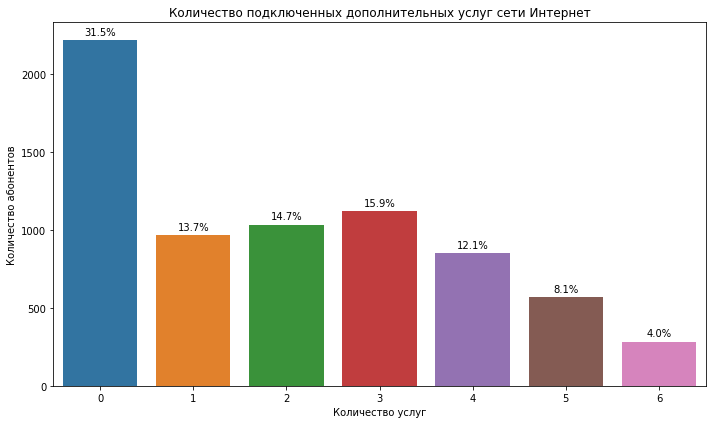

In [33]:
# Визуализируем данные нового признака 'OptionsCount'

column = "OptionsCount"  

# Настраиваем размер окна
fig, ax = plt.subplots(figsize=(10, 6))  # Устанавливаем нужный размер окна

# Строим столбчатую диаграмму
sns.countplot(data=teledom, x=column, ax=ax)

# Задаем название графика и подписи осей
ax.set_title('Количество подключенных дополнительных услуг сети Интернет')  # Название диаграммы
ax.set_xlabel('Количество услуг')  # Ось X
ax.set_ylabel('Количество абонентов')  # Ось Y

add_percentage_labels(ax)  # Добавляем подписи количества

plt.tight_layout()
plt.show()


**Комментарии**

Треть пользователей не пользуются дополнительными услугами сети Интернет, значения от 1 до 4 услуг распределены примерно равномерно.

In [34]:
# Рассчитываем матрицу корреляций phi-k с новыми данными

corr_matrix_new = teledom.phik_matrix(interval_cols=interval_cols)
display(corr_matrix_new)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,quit,period,OptionsCount
Type,1.000000,0.106860,0.277462,0.388266,0.470275,0.086231,0.179736,0.147680,0.505187,0.244410,0.094015,0.634155,0.484338
PaperlessBilling,0.106860,1.000000,0.370495,0.467783,0.201903,0.242133,0.013218,0.172593,0.231438,0.099953,0.083398,0.026799,0.235657
PaymentMethod,0.277462,0.370495,1.000000,0.399536,0.335855,0.292725,0.243008,0.224903,0.323886,0.174849,0.214832,0.350964,0.311522
MonthlyCharges,0.388266,0.467783,0.399536,1.000000,0.711090,0.304691,0.203237,0.184213,0.918980,0.710101,0.225925,0.387579,0.771286
TotalCharges,0.470275,0.201903,0.335855,0.711090,1.000000,0.135994,0.382837,0.084325,0.490121,0.468127,0.303275,0.848097,0.584179
SeniorCitizen,0.086231,0.242133,0.292725,0.304691,0.135994,1.000000,0.016992,0.324576,0.160702,0.087925,0.086159,0.063315,0.122972
Partner,0.179736,0.013218,0.243008,0.203237,0.382837,0.016992,1.000000,0.652122,0.000000,0.086249,0.226688,0.453688,0.209510
Dependents,0.147680,0.172593,0.224903,0.184213,0.084325,0.324576,0.652122,1.000000,0.108463,0.011198,0.046871,0.198729,0.114160
InternetService,0.505187,0.231438,0.323886,0.918980,0.490121,0.160702,0.000000,0.108463,1.000000,0.739808,0.056621,0.060845,0.647446
MultipleLines,0.244410,0.099953,0.174849,0.710101,0.468127,0.087925,0.086249,0.011198,0.739808,1.000000,0.105101,0.347289,0.355873


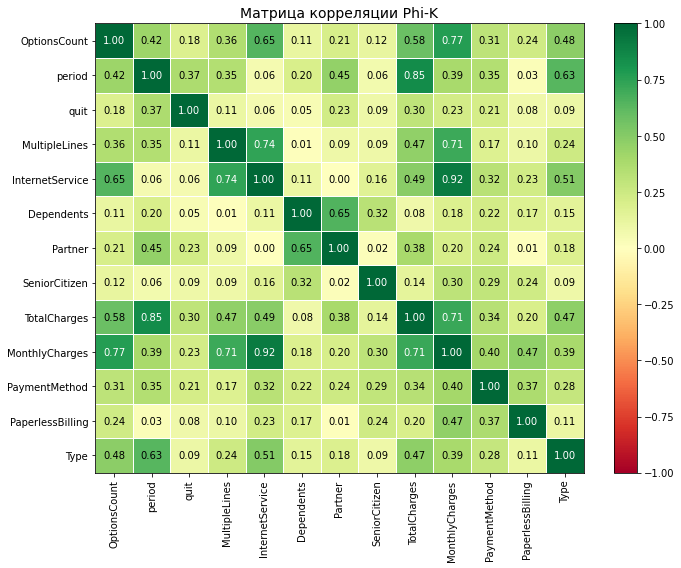

In [35]:
# Отображение корреляционной матрицы в виде тепловой карты

plot_correlation_matrix(corr_matrix_new.values,
                        x_labels=corr_matrix_new.columns,
                        y_labels=corr_matrix_new.index,
                        title='Матрица корреляции Phi-K',
                        figsize=(10,8))
plt.show()

**Комментарии**

После создания нового признака `OptionsCount` и удаления лишних признаков значения кореляции стали более понятными. Присутствует высокая корреляция между признаками, обозначающими тип услуг, и признаками стоимости расходов, что логично. Чем больше услуг, тем выше стоимость тарифа. Однако, несмотря на создание новых признаков, у нас не появилось признаков, имеющих высокую корреляцию с целевым признаком `quit`.

**Вывод**

На данном этапе мы объединили исходные датафреймы в один общий, предобработали его и изучили. Исследовательский анализ объединенного датафрейма с данными абонентов оператора связи "ТелеДом" показал:
- Распределение абонентов по полу, также как и по семейному положению, практически 50/50.
- Всего 16.2% абонентов являются пенсионерами. 
- Большая часть абонентов не имеют детей (70%). 
- Больше половины абонентов (55%) используют помесячную оплату услуг. 
- Почти 60% абонентов используют электронный расчетный счет. 
- Распределение типов платежей примерно равномерно (20-30%), преобладает элетронная оплата. 
- Большое количество абонентов имеют минимальные расходы за месяц (около 20), далее с увеличением трат есть также несколько небольших пиков (50, 70, 80, 90, 100), возможно это цены на базовые тарифы без доп.услуг. 
- Рассматривая гистограмму общих трат также можно заметить пик в самом начале, из чего можно предположить, что в датасете много абонентов, которые недавно зарегистрировались или недолго пользовались услугали компании. Возможно, такое распределение отражает популярную тенденцию промо-тарифов для новых пользователей. 
- Чуть больше 20% пользователей не используют услуги сети Интернет и дополнительные опции к ним.
- Услугой подключения телефона к нескольким линиям одновременно пользуются чуть больше 40% абонентов, а чуть меньше 10% абонентов не подключили телефонную связь вообще.
- Чуть меньше половины абонентов используют оптоволоконное подключение (44%).
- Присутствует дисбаланс классов целевого признака: 84%/16%.
- Самый длинный договор используется более 6 лет, а средняя длительность пользования услугами составляет 1,8-2 года. При этом важно отметить, что в данных довольно много абонентов, которые пользуются услугами меньше года.
- Анализируя матрицу корреляции Phi-K, можно сделать вывод, что наиболее выраженная связь между целевым признаком `quit` у входных признаков `period` (0.37), `TotalCharges` (0.30), `MonthlyCharges` и `Partner` (0.23). 

## Обучение и анализ моделей.

### Подготовка данных в пайплайне.


Для подготовки признаков будем использовать:
- MinMaxScaler/StandartScaler для стобцов `MonthlyCharges`, `TotalCharges`, `period`, `OptionsCount`.
- OneHotEncoder для столбцов `Type`, `PaperlessBilling`, `PaymentMethod`, `SeniorCitizen`, `Partner`, `Dependents`, `InternetService`, `MultipleLines`.

In [36]:
# Удаляем целевой признак

X = teledom.drop('quit', axis=1)

# Сохраняем целевой признак

y = teledom['quit']

In [37]:
# Разбиваем данные на обучающую и тестовую выборки в соотношении 75:25.

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE,
        test_size=0.25,
    )

In [38]:
# Определяем тип признаков для пайплайна

ohe_columns = ['Type', 'PaperlessBilling',  'PaymentMethod', 'SeniorCitizen',
              'Partner', 'Dependents', 'InternetService', 'MultipleLines']
num_columns = ['MonthlyCharges', 'TotalCharges', 'period', 'OptionsCount']

In [39]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование

ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [40]:
# Создаём общий пайплайн для подготовки данных

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [41]:
# Cоздаём пайплайн для модели LogisticRegression: подготовка данных и модель

pipe_log = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [42]:
# Создаем сетку гиперпараметров для модели логистической регрессии

param_grid_log = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear', 
            penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [43]:
# Cоздаём пайплайн для модели DecisionTreeClassifier: подготовка данных и модель

pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [44]:
# Создаем сетку гиперпараметров для модели DecisionTreeClassifier

param_grid_tree = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(5, 10),
        'models__min_samples_leaf': range(2, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [45]:
# Cоздаём пайплайн для модели LGBMClassifier: подготовка данных и модель

pipe_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMClassifier(random_state=RANDOM_STATE, verbose=-1))
])

In [46]:
# Создаем сетку гиперпараметров для модели LGBMRegressor

param_grid_lgbm = [
    {
    'models': [LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)],
    'models__n_estimators': range(50, 100, 10),
    'models__max_depth': range(3, 8)
    }
]

### Обучение моделей машинного обучения

In [47]:
# Функция для обучения моделей

def ml_model(X_train, y_train, pipe, param_grid):
    
    start_time = time.time()  # начинаем замер общего времени
    
    # Поиск наилучшей модели
    randomized_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=20,
        cv=5,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        error_score="raise",
    )
    
    randomized_search.fit(X_train, y_train)
    
    end_time = time.time()  # заканчиваем замер общего времени
    all_time = end_time - start_time
    print(f"Время полного процесса поиска: {all_time:.2f} секунд")
    
#     # Извлекаем подробный отчет
#     results_df = pd.DataFrame(randomized_search.cv_results_)
    
#     # Оставляем нужные колонки
#     selected_columns = [
#         'mean_test_score',       # среднее значение оценки теста
#         'rank_test_score',       # ранг модели среди остальных
#         'params',                # параметры модели
#         'mean_fit_time',         # среднее время обучения
#         'mean_score_time'        # среднее время предсказания
#     ]
    
#     report = results_df[selected_columns]
        
#     # Показываем отчёт
#     print("Отчёт по результатам поиска:\n")
#     display(report.sort_values(by=['rank_test_score'], ascending=True).reset_index(drop=True))
    
    # Информация о лучшей модели
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_roc_auc = randomized_search.best_score_
    
    print('Лучшая модель:\n')
    print(best_model)
    print('Параметры лучшей модели:', best_params)
    print('ROC-AUC лучшей модели на кросс-валидации:', best_roc_auc)
    
    return randomized_search

In [48]:
%%time
# Обучим модель линейной регрессии

model_log = ml_model(X_train, y_train, pipe_log, param_grid_log)

Время полного процесса поиска: 26.47 секунд
Лучшая модель:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen

In [49]:
%%time
# Обучим модель DecisionTreeRegressor

model_tree = ml_model(X_train, y_train, pipe_tree, param_grid_tree)

Время полного процесса поиска: 4.63 секунд
Лучшая модель:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen'

In [50]:
%%time
warnings.filterwarnings("ignore")
# Обучим модель LGBMClassifier

model_lgbm = ml_model(X_train, y_train, pipe_lgbm, param_grid_lgbm)

Время полного процесса поиска: 535.20 секунд
Лучшая модель:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitize

**Комментарии**

Для поиска лучших параметров моделей для предсказания оттока клиентов оператора связи "ТелеДом" был использован инструмент `RandomizedSearchCV`, который анализировал различные параметры для моделей `LogisticRegression()`, `DecisionTreeClassifier()` и `LGBMClassifier()`. 

Достигнув метрики ROC-AUC в 0.853 на кросс-валидации лучшей стала модель со следующими параметрами: LGBMClassifier(max_depth=6, n_estimators=90,random_state=201025, verbose=-1)). 

Теперь, проверим её качество на тестовой выборке.

### Проверка модели на тестовых данных 

In [51]:
%%time
# Проверим работу модели LightGBM на тестовой выборке

best_model_lgbm = model_lgbm.best_estimator_
y_test_proba = best_model_lgbm.predict_proba(X_test)[:, 1]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.8922308546059933
CPU times: user 47.2 ms, sys: 4.04 ms, total: 51.3 ms
Wall time: 86.2 ms


**Комментарии**

Метрика ROC-AUC на тестовой выборке составила 0.89, что является критерием успеха. 

In [52]:
# Проверим модель с помощью DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)

y_pred_dummy = dummy_classifier.predict(X_test)
y_proba_dummy = dummy_classifier.predict_proba(X_test)[:, 1]
y_test_pred = best_model_lgbm.predict(X_test)
y_test_proba = best_model_lgbm.predict_proba(X_test)[:, 1]

print("Метрика Accuracy лучшей модели:", accuracy_score(y_test, y_test_pred))
print("Метрика Accuracy Dummy classifier:", accuracy_score(y_test, y_pred_dummy))
print("Метрика ROC-AUC на тестовой выборке:", roc_auc_score(y_test, y_test_proba))
print("Метрика ROC-AUC Dummy classifier:", roc_auc_score(y_test, y_proba_dummy))

Метрика Accuracy лучшей модели: 0.8949460533787621
Метрика Accuracy Dummy classifier: 0.8495173197047132
Метрика ROC-AUC на тестовой выборке: 0.8922308546059933
Метрика ROC-AUC Dummy classifier: 0.5


**Комментарии**

Метрика ROC-AUC DummyClassifier на тестовой выборке - 0.5, что соответствует качеству случайно модели. 

Метрика Accuracy DummyClassifier ниже, чем у лучшей модели. Важно отметить, что высокая метрика Accuracy у DummyClassifier вызвана дисбалансом классов и выбором стратегии "most_frequent".

Можно сделать вывод, что наша модель хорошо справляется с поставленной ей задачей. 

### Анализ важность признаков

In [53]:
# Подготовим данные для SHAP-анализа

model = best_model_lgbm.named_steps['models'] 
preprocessor_pipe = best_model_lgbm.named_steps['preprocessor']
X_train_scalled = preprocessor_pipe.fit_transform(X_train)
X_test_scalled = preprocessor_pipe.transform(X_test)
feature_names = best_model_lgbm[:-1].get_feature_names_out()

# Создаем Explainer

explainer = shap.TreeExplainer(model)

# Получаем SHAP-значения для данных

shap_values = explainer(X_test_scalled)

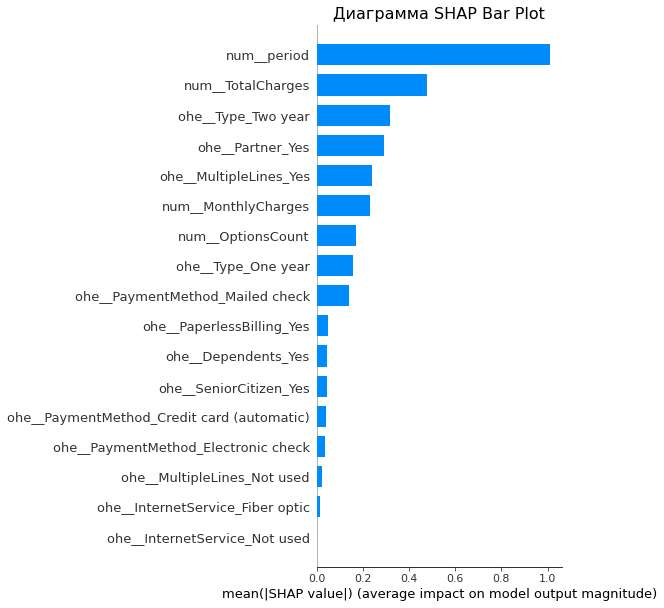

In [54]:
# Визуализиурем важность признаков SHAP Bar Plot

fig, ax = plt.subplots(figsize=(10, 12)) # задаем размер фигуры
shap.summary_plot(
    shap_values,
    X_train_scalled,
    show=False,           # отключаем автоматическое отображение, чтобы добавить заголовок вручную
    feature_names=feature_names, # имена признаков для осей
    plot_type="bar"
)

plt.title("Диаграмма SHAP Bar Plot", fontsize=16)
plt.show()

**Комментарии**

Диаграмма  Bar Plot используется для визуализации важности различных признаков в модели машинного обучения. Ось X показывает среднее значение абсолютного SHAP-значения для каждого признака. Чем больше значение, тем сильнее признак влияет на предсказание модели. Ось Y перечисляет признаки, упорядоченные по их важности. Признаки с наибольшим влиянием находятся в верхней части диаграммы. Цвета обычно используются для обозначения направления влияния признака на предсказание. Красный цвет может указывать на положительное влияние, а синий — на отрицательное. 

Диаграмма показывает, что наиболее важными признаками для модели являются `num_period`, `num_TotalCharges`, `ohe_Type_Two year` и `ohe_Partner_Yes`. Эти признаки оказывают наибольшее влияние на предсказание модели. Остальные признаки также вносят свой вклад, но их влияние менее значительно. Таким образом, наиболее значимыми признаками, влияющими на длительное пользование услугами стали: длительность договора, общие затраты, тип оплаты за 2 года вперед и наличие супруга/супруги. 

### Матрица ошибок

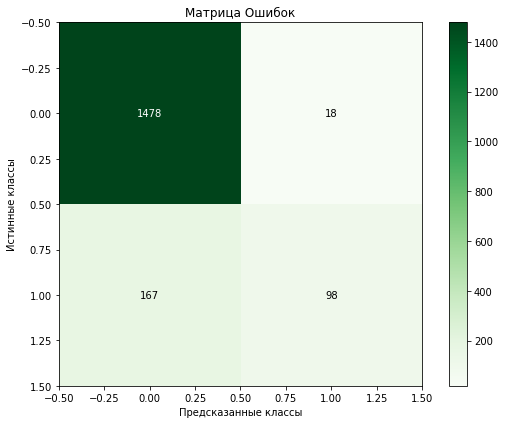

In [55]:
# Посчитаем матрицу ошибок

cm = confusion_matrix(y_test, np.round(y_test_pred))

# Визуализируем матрицу ошибок

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest',  cmap=plt.cm.Greens)
plt.title("Матрица Ошибок")
plt.colorbar()
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.tight_layout()
plt.show()

**Комментарии**

Наша модель 1478 раз предсказала правильно, что абонент продолжит пользоваться услугами оператора связи "ТелеДом", а также 98 раз был верно предсказано расторжение договора. Количество ошибок FN: 167, FP: 18. В дальнейшем по согласованию с заказчиком в зависимости от приоритетов можно изменить пороги классификации, для изменения баланса FN и FP. 

**Выводы**

Для выбора лучшей модели заказчику было важно учитывать качество (значение метрики  ROC-AUC  должно быть больше 0.85) и скорость предсказания.

Достигнув метрики ROC-AUC в 0.853 на кросс-валидации, и 0.892 на тестовых данных, лучше всех себя показала модель `LGBMClassifier`.

Модель LightGBM справилась лучше линейной регрессии и дерева решений, так как увереннее работает при нелинейной зависимости признаков, а, учитывая матрицу корреляции, можно сказать, что в наших данных признаков с такой зависимостью много. Более того эта модель эффективно обрабатывает шумы и неоднородности данных, что обусловлено наличием методов регуляризации и мощным механизмом ансамблевого обучения. Хотя бустинг обучается дольше других моделей, точность предсказания у этой модели выше, поэтому рекомендуется ее использование для задачи прогнозирования оттока клиентов.

Анализируя признаки, оказывающие влияние на вероятность расторжения договора, важно отметить, что длительность договора и тип оплаты являются ведущими. Возможно, оператору связи "ТелеДом" имеет смысл разработать систему скидок и акций для оплаты тарифов на длительный период (1-2 года). Это может помочь удержать уже имеющихся пользователей, так как они более лояльны к компании. Для привлечения новых клиентов можно предложить бесплатный пробный период с дальнейшим переходом на длительный тариф. 

## Общий вывод и рекомендации заказчику.

Для настоящего проекта нам были предоставлены данные оператора связи «ТелеДом», который хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.

**Цель исследования**: Построить модель машинного обучения, с помощью которой появится возможность прогноза оттока клиентов. 

В **первом разделе** проекта мы загрузили данные и изучили общую информацию о них, провели основную предобработку и исследовательский анализ. 

Нам для анализа были предоставлены персональные данные о некоторых клиентах, информация об их тарифах и услугах. Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Информация о договорах актуальна на 1 февраля 2020 года. Все файлы объединены по идентификатору пользователя `customerID`.

Во **втором разделе** проекта объединили данные, провели их подготовку и исследовательский анализ. 

Мы создали три новых признака:
- `quit` - целевой признак (0 - договор действителен, 1 - договор расторгнут).
- `period` - количество дней использования договора.
- `OptionsCount`- общее количество подключенных услуг сети Интернет.

По результатам исследовательского анализа объединенного датафрейма можно сделать следующие выводы:
- Распределение абонентов по полу, также как и по семейному положению, практически 50/50.
- Всего 16.2% абонентов являются пенсионерами. 
- Большая часть абонентов не имеют детей (70%). 
- Больше половины абонентов (55%) используют помесячную оплату услуг. 
- Почти 60% абонентов используют электронный расчетный счет. 
- Распределение типов платежей примерно равномерно (20-30%), преобладает электронная оплата. 
- Большое количество абонентов имеют минимальные расходы за месяц (около 20), далее с увеличением трат есть также несколько небольших пиков (50, 70, 80, 90, 100), возможно это цены на базовые тарифы без доп.услуг. 
- Рассматривая гистограмму общих трат также можно заметить пик в самом начале, из чего можно предположить, что в датасете много абонентов, которые недавно зарегистрировались или недолго пользовались услугали компании. Возможно, такое распределение отражает популярную тенденцию промо-тарифов для новых пользователей. 
- Чуть больше 20% пользователей не используют услуги сети Интернет и дополнительные опции к ним.
- Услугой подключения телефона к нескольким линиям одновременно пользуются чуть больше 40% абонентов, а чуть меньше 10% абонентов не подключили телефонную связь вообще.
- Чуть меньше половины абонентов используют оптоволоконное подключение (44%).
- Присутствует дисбаланс классов целевого признака: 84%/16%.
- Самый длинный договор используется более 6 лет, а средняя длительность пользования услугами составляет 1,8-2 года. При этом важно отметить, что в данных довольно много абонентов, которые пользуются услугами меньше года.
- Анализируя матрицу корреляции Phi-K, можно сделать вывод, что наиболее выраженная связь между целевым признаком `quit` у входных признаков `period` (0.37), `TotalCharges` (0.30), `MonthlyCharges` и `Partner` (0.23). 

В **третьем разделе** разделили данные на обучающую и тестовую выборки. Далее мы подготовили пайплайн и использовали инструмент `RandomizedSearchCV` для поиска лучшей модели. Были проанализированы различные параметры моделей `LGBMClassifier()`, `DecisionTreeClassifier()` и `LogisticRegression()`. Для выбора лучшей модели заказчику было важно учитывать качество (значение метрики  ROC-AUC  должно быть больше 0.85) и скорость предсказания.

Достигнув метрики **ROC-AUC в 0.853** на кросс-валидации, и **0.892** на тестовых данных, лучше всех себя показала модель `LGBMClassifier (max_depth=6, n_estimators=90,random_state=201025, verbose=-1))`.

Анализируя признаки, оказывающие влияние на вероятность расторжения договора, важно отметить, что длительность договора и тип оплаты являются ведущими. Возможно, оператору связи "ТелеДом" имеет смысл разработать систему скидок и акций для оплаты тарифов на длительный период (1-2 года). Это может помочь удержать уже имеющихся пользователей, так как они более лояльны к компании. Для привлечения новых клиентов можно предложить бесплатный пробный период с дальнейшим переходом на длительный тариф. 

Таким образом, по итогам проведенного анализа и разработки моделей машинного обучения появится возможность прогнозировать отток клиентов и предлагать им промокоды и специальные условия, что снизит потенциальные риски и финансовые потери компании «ТелеДом».